In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

ModuleNotFoundError: No module named 'torch'

### 生成训练集

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.from_numpy(np.random.normal(0,1,(num_examples, num_inputs)))
labels =  true_w[0] * features[:, 0]  + true_w[1] * features[:, 1] +true_b
labels += torch.from_numpy(np.random.normal(0,  0.0001 , size=labels.size()))
features = features.float()
labels = labels.float()

In [3]:
print(features[0], labels[0])

tensor([0.8997, 1.3814]) tensor(1.3026)


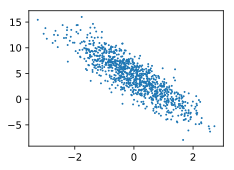

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

In [5]:
def data_iter(batch_size, features,labels):
    num_examples = len(labels)
    num_batch = num_examples // batch_size +1
    indices = list (range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-2.1057,  1.1363],
        [ 1.2824, -0.1706],
        [ 0.1618,  0.1805],
        [ 0.9715, -1.1638],
        [-0.1534,  1.5258],
        [-1.9684, -0.7410],
        [ 0.3554,  0.5517],
        [-1.2616, -0.0213],
        [ 0.1665, -0.7934],
        [ 0.1848,  0.0547]]) tensor([-3.8748,  7.3447,  3.9099, 10.1000, -1.2944,  2.7826,  3.0349,  1.7492,
         7.2307,  4.3836])


In [7]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [8]:
w

tensor([[-0.0005],
        [ 0.0012]])

In [9]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`mm`函数做矩阵乘法。




In [10]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [11]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size()))**2/2

## 3.2.6 定义优化算法

以下的`sgd`函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。


In [12]:
def sgd(params,  lr , batch_size):
    for param in params:
        param.data -= lr * param.grad/batch_size

## 3.2.7 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失`l`的形状为(10, 1)。回忆一下自动求梯度一节。由于变量`l`并不是一个标量，所以我们可以调用`.sum()`将其求和得到一个标量，再运行`l.backward()`得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range (num_epochs):
    for X,y in data_iter(batch_size, features,labels):
        L = loss (net(X, w, b), y ).sum()
        L.backward()
        sgd([w, b], lr, batch_size)
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_L = loss(net(features,w,b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_L.mean().item()))



epoch 1, loss 0.028259
epoch 2, loss 0.000049
epoch 3, loss 0.000000


In [14]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0000],
        [-3.3997]], requires_grad=True)
4.2 
 tensor([4.1997], requires_grad=True)


# 3.3 线性回归的简洁实现

随着深度学习框架的发展，开发深度学习应用变得越来越便利。实践中，我们通常可以用比上一节更简洁的代码来实现同样的模型。在本节中，我们将介绍如何使用PyTorch更方便地实现线性回归的训练。

## 3.3.1 生成数据集

我们生成与上一节中相同的数据集。其中`features`是训练数据特征，`labels`是标签。

In [39]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0,1,(num_examples, num_inputs)))
labels = true_w[0] * features[: , 0] +true_w[1] * features[:, 1] +true_b
print(labels.size())
labels = labels + torch.tensor(np.random.normal(0, 0.01,size = labels.size() ))
features = features.float()
labels = labels.float()

torch.Size([1000])


## 3.3.2 读取数据

PyTorch提供了`data`包来读取数据。由于`data`常用作变量名，我们将导入的`data`模块用`Data`代替。在每一次迭代中，我们将随机读取包含10个数据样本的小批量。

In [40]:
import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

In [41]:
for X,y in data_iter:
    print(X, y)
    break

tensor([[-0.1301, -0.0600],
        [ 2.1905, -1.1386],
        [-2.3429,  0.2228],
        [-1.2587,  1.5800],
        [ 0.3480,  0.3646],
        [-0.2920,  0.2623],
        [-0.7319,  1.8009],
        [-1.9675,  0.8929],
        [-0.7350, -0.6411],
        [ 1.0513, -0.4733]]) tensor([ 4.1549, 12.4626, -1.2377, -3.6999,  3.6618,  2.7218, -3.3882, -2.7726,
         4.8866,  7.8967])


### 定义模型

In [42]:
import torch.nn as nn

In [43]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super (LinearNet,self).__init__()
        self.linear = nn.Linear(n_feature, 1)
        #forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y
    
net  = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


事实上我们还可以用`nn.Sequential`来更加方便地搭建网络，`Sequential`是一个有序的容器，网络层将按照在传入`Sequential`的顺序依次被添加到计算图中。

In [44]:
# # 写法一
# net = nn.Sequential(
#     nn.Linear(num_inputs, 1)
#     # 此处还可以传入其他层
#     )

# # 写法二
# net = nn.Sequential()
# net.add_module('linear', nn.Linear(num_inputs, 1))
# # net.add_module ......
net =[3]
# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs,1)) 
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [45]:
for para in net.parameters():
    print(para)

Parameter containing:
tensor([[-0.3878, -0.2218]], requires_grad=True)
Parameter containing:
tensor([-0.0856], requires_grad=True)


In [72]:
from torch.nn import init
init.normal_(net[0].weight , mean = 0, std =0.01)
init.constant_(net[0].bias , val=0)  # 也可以直接修改bias的data: net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

In [73]:
loss = nn.MSELoss()

In [74]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr = 0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [75]:
'''python
optimizer =optim.SGD([
                # 如果对某个参数不指定学习率，就使用最外层的默认学习率
                {'params': net.subnet1.parameters()}, # lr=0.03
                {'params': net.subnet2.parameters(), 'lr': 0.01}
            ], lr=0.03)
'''

"python\noptimizer =optim.SGD([\n                # 如果对某个参数不指定学习率，就使用最外层的默认学习率\n                {'params': net.subnet1.parameters()}, # lr=0.03\n                {'params': net.subnet2.parameters(), 'lr': 0.01}\n            ], lr=0.03)\n"

In [76]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍

In [79]:
num_epochs = 8
for epoch in range(1, num_epochs+1):
    for X,y in data_iter:
        output = net(X)
        I = loss (output, y.view(-1,1))
        optimizer.zero_grad()
        I.backward()
        optimizer.step()
    print('epoch %d, loss:%f' %(epoch, I.item()))

epoch 1, loss:0.000112
epoch 2, loss:0.000094
epoch 3, loss:0.000073
epoch 4, loss:0.000095
epoch 5, loss:0.000068
epoch 6, loss:0.000130
epoch 7, loss:0.000158
epoch 8, loss:0.000043


In [1]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

NameError: name 'net' is not defined

## 小结

* 使用PyTorch可以更简洁地实现模型。
* `torch.utils.data`模块提供了有关数据处理的工具，`torch.nn`模块定义了大量神经网络的层，`torch.nn.init`模块定义了各种初始化方法，`torch.optim`模块提供了模型参数初始化的各种方法。

-----------
> 注：本节除了代码之外与原书基本相同，[原书传送门](https://zh.d2l.ai/chapter_deep-learning-basics/linear-regression-gluon.html)